In [1]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from utils import remove_all_ticks_and_labels
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

# device = 'cpu'
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}', flush=True)

Using device: cpu


what are the effects of an architecture with skip connections?

In [65]:
from utils import save_model_weights
from dataset_utils import load_trimodal_data, load_unimodal_data, load_unimodal_data_3d, load_unimodal_data_nd, generate_2d_swiss_roll
from models import VariableDendriticCircuit, VariableDendriticCircuitWithSkipConnections

# ---------------------------------- params ---------------------------------- #
dataset_size = 2e3
num_ambient_dims = 2
num_hiddens = [
        [2, 2, 2, 2, 2, 2, 2, 2, 3, 3],
        [3, 3, 3, 3, 3, 3, 4],
        [4, 4, 4, 4, 4, 3],
        [5, 5, 5, 5, 5],
        [8, 8, 7, 7],
        [59, 59]
    ]
num_hidden = num_hiddens[-1]
bias=True

# ------------------------------ define dataset ------------------------------ #
dataset = generate_2d_swiss_roll(dataset_size, rescaled=True, return_as_tensor=True)[1]
# dataset = load_unimodal_data_nd(dataset_size, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)

# -------------------------------- load model -------------------------------- #
model_sc = VariableDendriticCircuitWithSkipConnections(
    hidden_cfg=num_hidden, 
    num_in=num_ambient_dims, 
    num_out=num_ambient_dims, 
    bias=bias
)

model = VariableDendriticCircuit(
    hidden_cfg=num_hidden, 
    num_in=num_ambient_dims, 
    num_out=num_ambient_dims, 
    bias=bias
)

# print(num_hidden)

In [66]:
print(model)
print(model_sc)

VariableDendriticCircuit(
  (nonlin): ReLU()
  (features): MySequential(
    (0): NoiseConditionalLinearConcat1(
      (linear): Linear(in_features=3, out_features=6962, bias=True)
    )
    (1): ReLU()
    (2): DendriticBranchLayer()
    (3): ReLU()
    (4): DendriticBranchLayer()
  )
)
VariableDendriticCircuitWithSkipConnections(
  (nonlin): ReLU()
  (fc_layer): MySequential(
    (0): NoiseConditionalLinearConcat1(
      (linear): Linear(in_features=3, out_features=6962, bias=True)
    )
    (1): ReLU()
  )
  (features): MySequential(
    (0): DendriticBranchLayerWithSkipConnections()
    (1): ReLU()
    (2): DendriticBranchLayerWithSkipConnections()
  )
)


In [69]:
# model.features[2].layer_weights.shape
print(model_sc.features[2].layer_weights.shape)
print(model_sc.features[2].branch_factor)

torch.Size([2, 62])
59


In [70]:
model_sc.fc_layer

MySequential(
  (0): NoiseConditionalLinearConcat1(
    (linear): Linear(in_features=3, out_features=6962, bias=True)
  )
  (1): ReLU()
)

In [71]:
model = model_sc

# train

In [75]:
# ------------------------------ training params ----------------------------- #
num_steps = 100
forward_schedule = 'sine'
num_epochs = 50+1
batch_size = 256
lr = 3e-4
l1_reg = 0
l1_reg_on_phase_weights = True

from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from prior_utils import forward_process
from utils import noise_estimation_loss

coefs = forward_process(num_steps, device, forward_schedule)
betas, alphas, alphas_prod, alphas_prod_p, alphas_bar_sqrt, one_minus_alphas_prod_log, one_minus_alphas_prod_sqrt = coefs
alphas_bar_sqrt = alphas_bar_sqrt.to(device)
one_minus_alphas_prod_sqrt = one_minus_alphas_prod_sqrt.to(device)

# training set
dataset = dataset.to(device)
model.to(device)

# training parameteres
optimizer = optim.Adam(model.parameters(), lr=lr)
model_name = 'VDC'
model_number = 1
run_dir = os.path.join(base_dir, 'demos/runs', f'{model_name}_{model_number}')
tb = SummaryWriter(run_dir)
losses = []
# start_time = time.time()

# start training
model.train()
for t in tqdm(range(int(num_epochs)), total=int(num_epochs), desc='Training model', unit='epochs', miniters=int(num_epochs)/1000, maxinterval=float("inf")):
    permutation = torch.randperm(dataset.size()[0], device=device)

    for i in range(0, dataset.size()[0], batch_size):
        # retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        
        # compute the loss
        loss = noise_estimation_loss(model, batch_x, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', l1_reg=l1_reg, l1_reg_on_phase_weights=l1_reg_on_phase_weights, has_class_label=False)
        # zero the gradients
        optimizer.zero_grad()
        # backward pass: compute the gradient of the loss wrt the parameters
        loss.backward()
        # call the step function to update the parameters
        optimizer.step()

    # write to tensorboard
    tb.add_scalar('Loss', loss.item(), t)
    losses.append(loss.item())
tb.flush()

Training model:   0%|          | 0/51 [00:00<?, ?epochs/s]

[None]

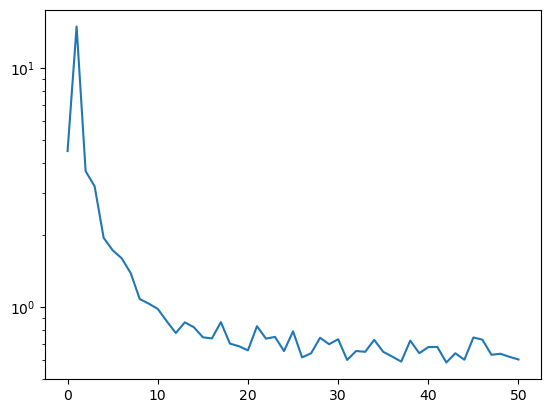

In [76]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set(yscale='log')

# inference

In [ ]:
# plot the scores
